# Import Dependencies

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats

sns.set()

from mpl_toolkits.mplot3d import Axes3D

from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV, cross_val_score
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.cluster import KMeans
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier

import xgboost as xgb

from keras.models import Sequential
from keras.layers import Dense
from keras.callbacks import EarlyStopping

%matplotlib inline

# Explore and Clean Dataset

## Leukemia Classes Data

In [2]:
cancer_type_df = pd.read_csv('cancer_genetics.csv')
cancer_type_df.head()

,patient,cancer
0,1,ALL
1,2,ALL
2,3,ALL
3,4,ALL
4,5,ALL


In [3]:
cancer_type_df['cancer'].value_counts()

ALL    47
AML    25
Name: cancer, dtype: int64

#### Since cancer types are classified as ALL and AML, we are going to translate these values to numerical inputs.

In [4]:
cancer_type_df = cancer_type_df.replace({'ALL':0, 'AML':1})

## Genetics Training Data

In [5]:
df_train = pd.read_csv('cancer_genetics_train.csv')
df_train.head()

,Gene Description,Gene Accession Number,1,call,2,call.1,3,call.2,4,call.3,...,29,call.33,30,call.34,31,call.35,32,call.36,33,call.37
0,AFFX-BioB-5_at (endogenous control),AFFX-BioB-5_at,-214,A,-139,A,-76,A,-135,A,...,15,A,-318,A,-32,A,-124,A,-135,A
1,AFFX-BioB-M_at (endogenous control),AFFX-BioB-M_at,-153,A,-73,A,-49,A,-114,A,...,-114,A,-192,A,-49,A,-79,A,-186,A
2,AFFX-BioB-3_at (endogenous control),AFFX-BioB-3_at,-58,A,-1,A,-307,A,265,A,...,2,A,-95,A,49,A,-37,A,-70,A
3,AFFX-BioC-5_at (endogenous control),AFFX-BioC-5_at,88,A,283,A,309,A,12,A,...,193,A,312,A,230,P,330,A,337,A
4,AFFX-BioC-3_at (endogenous control),AFFX-BioC-3_at,-295,A,-264,A,-376,A,-419,A,...,-51,A,-139,A,-367,A,-188,A,-407,A


In [6]:
df_train.shape

(7129, 78)

In [7]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7129 entries, 0 to 7128
Data columns (total 78 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   Gene Description       7129 non-null   object
 1   Gene Accession Number  7129 non-null   object
 2   1                      7129 non-null   int64 
 3   call                   7129 non-null   object
 4   2                      7129 non-null   int64 
 5   call.1                 7129 non-null   object
 6   3                      7129 non-null   int64 
 7   call.2                 7129 non-null   object
 8   4                      7129 non-null   int64 
 9   call.3                 7129 non-null   object
 10  5                      7129 non-null   int64 
 11  call.4                 7129 non-null   object
 12  6                      7129 non-null   int64 
 13  call.5                 7129 non-null   object
 14  7                      7129 non-null   int64 
 15  call.6               

In [8]:
df_train.isnull()

,Gene Description,Gene Accession Number,1,call,2,call.1,3,call.2,4,call.3,...,29,call.33,30,call.34,31,call.35,32,call.36,33,call.37
0,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
1,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
2,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
3,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
4,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7124,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
7125,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
7126,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
7127,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False


In [9]:
df_train.isnull().sum()

Gene Description         0
Gene Accession Number    0
1                        0
call                     0
2                        0
                        ..
call.35                  0
32                       0
call.36                  0
33                       0
call.37                  0
Length: 78, dtype: int64

In [10]:
df_train.isnull().sum().sum()

0

## Genetics Testing Data

In [11]:
df_test = pd.read_csv('cancer_genetics_test.csv')
df_test.head()

,Gene Description,Gene Accession Number,39,call,40,call.1,42,call.2,47,call.3,...,65,call.29,66,call.30,63,call.31,64,call.32,62,call.33
0,AFFX-BioB-5_at (endogenous control),AFFX-BioB-5_at,-342,A,-87,A,22,A,-243,A,...,-62,A,-58,A,-161,A,-48,A,-176,A
1,AFFX-BioB-M_at (endogenous control),AFFX-BioB-M_at,-200,A,-248,A,-153,A,-218,A,...,-198,A,-217,A,-215,A,-531,A,-284,A
2,AFFX-BioB-3_at (endogenous control),AFFX-BioB-3_at,41,A,262,A,17,A,-163,A,...,-5,A,63,A,-46,A,-124,A,-81,A
3,AFFX-BioC-5_at (endogenous control),AFFX-BioC-5_at,328,A,295,A,276,A,182,A,...,141,A,95,A,146,A,431,A,9,A
4,AFFX-BioC-3_at (endogenous control),AFFX-BioC-3_at,-224,A,-226,A,-211,A,-289,A,...,-256,A,-191,A,-172,A,-496,A,-294,A


In [12]:
df_test.shape

(7129, 70)

In [13]:
df_test.isnull().sum().sum()

0

## Removing Call Values and Reorganizing Labels

In [14]:
# Transform all the call values to numbers (not used in this version)
# df_train.replace(['A','P','M'],['1','2','3'], inplace=True)
# df_test.replace(['A','P','M'],['1','2','3'], inplace=True)

# Remove "call" columns from training and testing data
df_train_columns = [col for col in df_train.columns if "call" not in col]
df_test_columns = [col for col in df_test.columns if "call" not in col]

df_train = df_train[df_train_columns]
df_test = df_test[df_test_columns]

In [15]:
df_train.shape

(7129, 40)

In [16]:
df_train.columns

Index(['Gene Description', 'Gene Accession Number', '1', '2', '3', '4', '5',
       '6', '7', '8', '9', '10', '11', '12', '13', '14', '15', '16', '17',
       '18', '19', '20', '21', '22', '23', '24', '25', '26', '27', '34', '35',
       '36', '37', '38', '28', '29', '30', '31', '32', '33'],
      dtype='object')

In [17]:
df_test.shape

(7129, 36)

In [18]:
df_test.columns

Index(['Gene Description', 'Gene Accession Number', '39', '40', '42', '47',
       '48', '49', '41', '43', '44', '45', '46', '70', '71', '72', '68', '69',
       '67', '55', '56', '59', '52', '53', '51', '50', '54', '57', '58', '60',
       '61', '65', '66', '63', '64', '62'],
      dtype='object')

In [19]:
train_columns_titles = ['Gene Description', 'Gene Accession Number', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10',
       '11', '12', '13', '14', '15', '16', '17', '18', '19', '20', '21', '22', '23', '24', '25', 
       '26', '27', '28', '29', '30', '31', '32', '33', '34', '35', '36', '37', '38']

test_columns_titles = ['Gene Description', 'Gene Accession Number','39', '40', '41', '42', '43', '44', '45', '46',
       '47', '48', '49', '50', '51', '52', '53',  '54', '55', '56', '57', '58', '59',
       '60', '61', '62', '63', '64', '65', '66', '67', '68', '69', '70', '71', '72']

df_train = df_train.reindex(columns=train_columns_titles)
df_test = df_test.reindex(columns=test_columns_titles)

In [20]:
df_train.head()

,Gene Description,Gene Accession Number,1,2,3,4,5,6,7,8,...,29,30,31,32,33,34,35,36,37,38
0,AFFX-BioB-5_at (endogenous control),AFFX-BioB-5_at,-214,-139,-76,-135,-106,-138,-72,-413,...,15,-318,-32,-124,-135,-20,7,-213,-25,-72
1,AFFX-BioB-M_at (endogenous control),AFFX-BioB-M_at,-153,-73,-49,-114,-125,-85,-144,-260,...,-114,-192,-49,-79,-186,-207,-100,-252,-20,-139
2,AFFX-BioB-3_at (endogenous control),AFFX-BioB-3_at,-58,-1,-307,265,-76,215,238,7,...,2,-95,49,-37,-70,-50,-57,136,124,-1
3,AFFX-BioC-5_at (endogenous control),AFFX-BioC-5_at,88,283,309,12,168,71,55,-2,...,193,312,230,330,337,101,132,318,325,392
4,AFFX-BioC-3_at (endogenous control),AFFX-BioC-3_at,-295,-264,-376,-419,-230,-272,-399,-541,...,-51,-139,-367,-188,-407,-369,-377,-209,-396,-324


In [21]:
df_train.shape

(7129, 40)

## Transpose Datasets and Refine

In [22]:
X_train = df_train.T
X_test = df_test.T
X_train.head()

,0,1,2,3,4,5,6,7,8,9,...,7119,7120,7121,7122,7123,7124,7125,7126,7127,7128
Gene Description,AFFX-BioB-5_at (endogenous control),AFFX-BioB-M_at (endogenous control),AFFX-BioB-3_at (endogenous control),AFFX-BioC-5_at (endogenous control),AFFX-BioC-3_at (endogenous control),AFFX-BioDn-5_at (endogenous control),AFFX-BioDn-3_at (endogenous control),AFFX-CreX-5_at (endogenous control),AFFX-CreX-3_at (endogenous control),AFFX-BioB-5_st (endogenous control),...,Transcription factor Stat5b (stat5b) mRNA,Breast epithelial antigen BA46 mRNA,GB DEF = Calcium/calmodulin-dependent protein ...,TUBULIN ALPHA-4 CHAIN,CYP4B1 Cytochrome P450; subfamily IVB; polypep...,PTGER3 Prostaglandin E receptor 3 (subtype EP3...,HMG2 High-mobility group (nonhistone chromosom...,RB1 Retinoblastoma 1 (including osteosarcoma),GB DEF = Glycophorin Sta (type A) exons 3 and ...,GB DEF = mRNA (clone 1A7)
Gene Accession Number,AFFX-BioB-5_at,AFFX-BioB-M_at,AFFX-BioB-3_at,AFFX-BioC-5_at,AFFX-BioC-3_at,AFFX-BioDn-5_at,AFFX-BioDn-3_at,AFFX-CreX-5_at,AFFX-CreX-3_at,AFFX-BioB-5_st,...,U48730_at,U58516_at,U73738_at,X06956_at,X16699_at,X83863_at,Z17240_at,L49218_f_at,M71243_f_at,Z78285_f_at
1,-214,-153,-58,88,-295,-558,199,-176,252,206,...,185,511,-125,389,-37,793,329,36,191,-37
2,-139,-73,-1,283,-264,-400,-330,-168,101,74,...,169,837,-36,442,-17,782,295,11,76,-14
3,-76,-49,-307,309,-376,-650,33,-367,206,-215,...,315,1199,33,168,52,1138,777,41,228,-41


In [23]:
X_train.columns = X_train.iloc[1]
X_train = X_train.drop(["Gene Description", "Gene Accession Number"]).apply(pd.to_numeric)

X_test.columns = X_test.iloc[1]
X_test = X_test.drop(["Gene Description", "Gene Accession Number"]).apply(pd.to_numeric)

print(X_train.shape)
print(X_test.shape)
X_train.head()

(38, 7129)
(34, 7129)


Gene Accession Number,AFFX-BioB-5_at,AFFX-BioB-M_at,AFFX-BioB-3_at,AFFX-BioC-5_at,AFFX-BioC-3_at,AFFX-BioDn-5_at,AFFX-BioDn-3_at,AFFX-CreX-5_at,AFFX-CreX-3_at,AFFX-BioB-5_st,...,U48730_at,U58516_at,U73738_at,X06956_at,X16699_at,X83863_at,Z17240_at,L49218_f_at,M71243_f_at,Z78285_f_at
1,-214,-153,-58,88,-295,-558,199,-176,252,206,...,185,511,-125,389,-37,793,329,36,191,-37
2,-139,-73,-1,283,-264,-400,-330,-168,101,74,...,169,837,-36,442,-17,782,295,11,76,-14
3,-76,-49,-307,309,-376,-650,33,-367,206,-215,...,315,1199,33,168,52,1138,777,41,228,-41
4,-135,-114,265,12,-419,-585,158,-253,49,31,...,240,835,218,174,-110,627,170,-50,126,-91
5,-106,-125,-76,168,-230,-284,4,-122,70,252,...,156,649,57,504,-26,250,314,14,56,-25


## Visualize as Boxplot

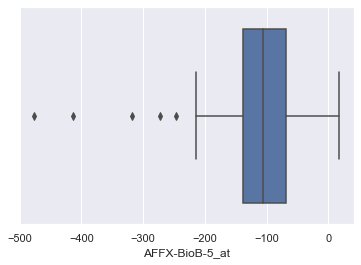

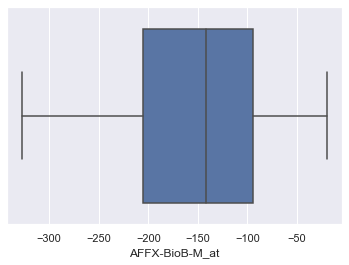

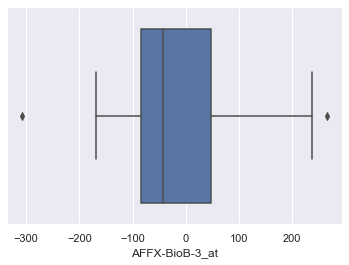

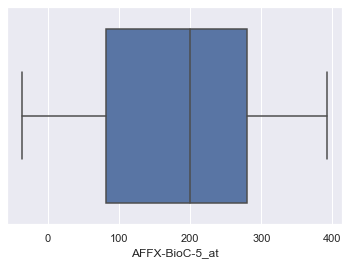

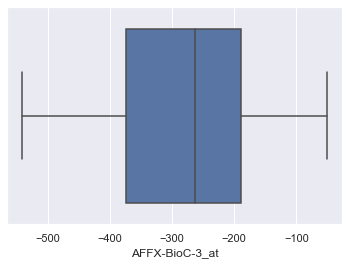

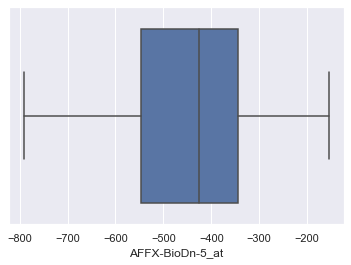

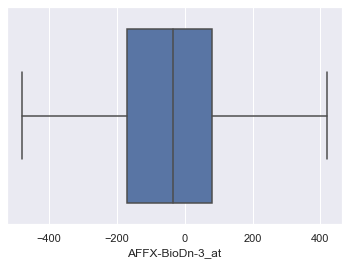

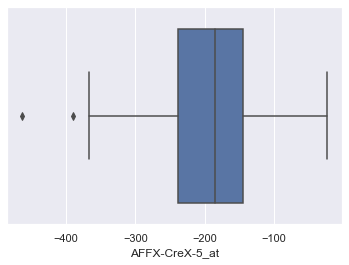

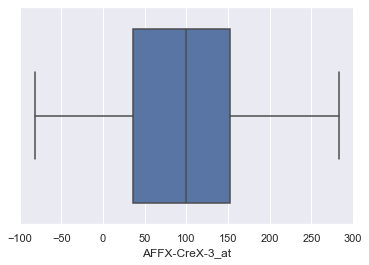

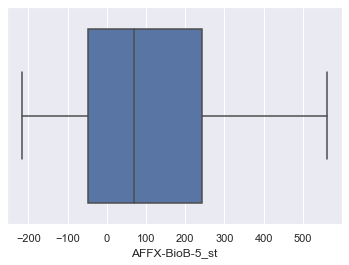

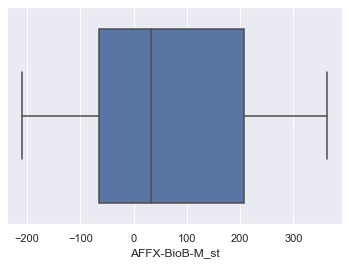

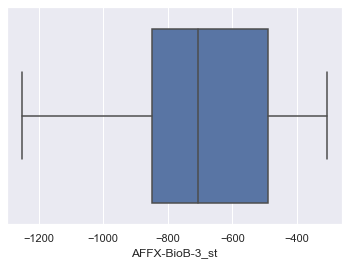

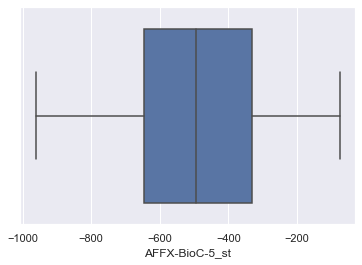

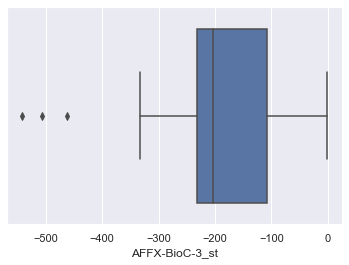

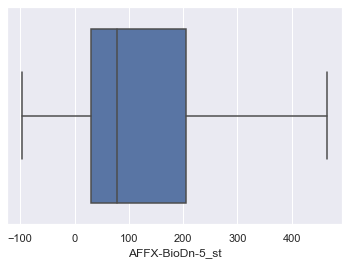

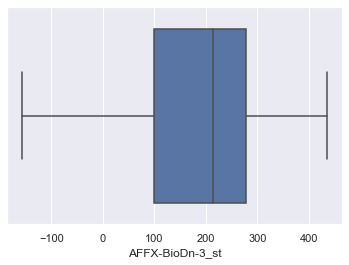

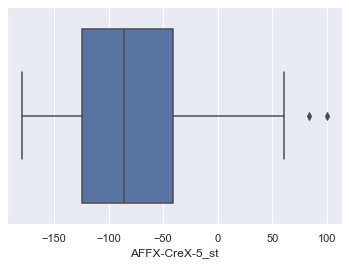

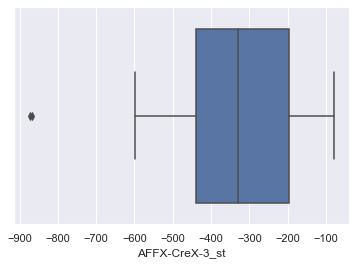

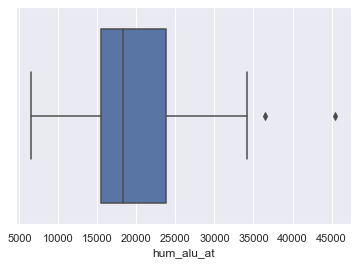

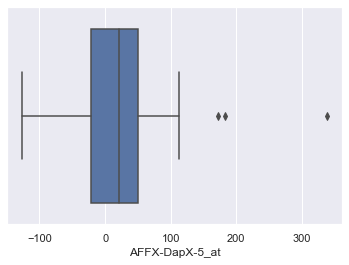

In [24]:
count = 0
for i in range(20):
    plt.figure(i)
    sns.boxplot(x=X_train[X_train.columns[i]])

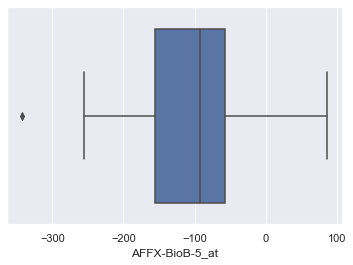

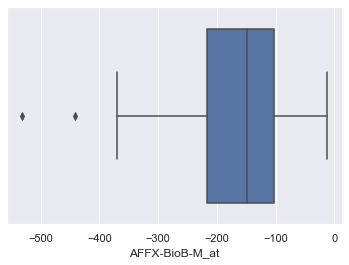

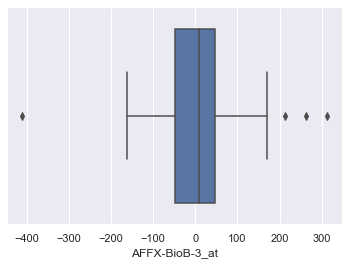

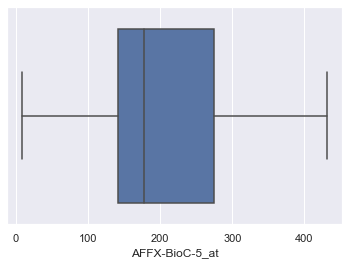

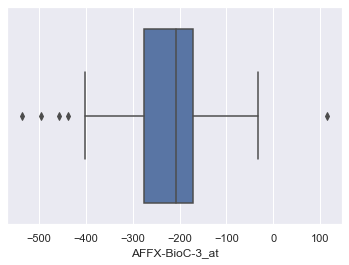

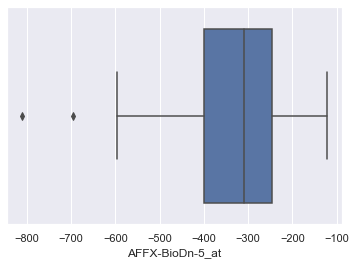

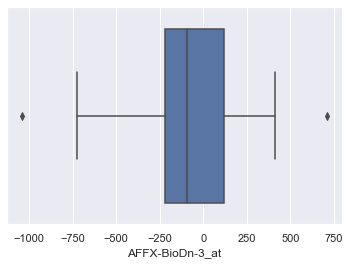

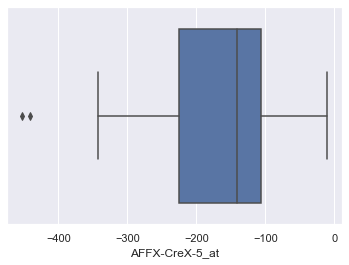

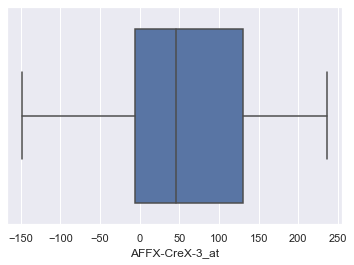

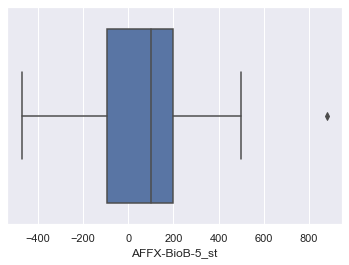

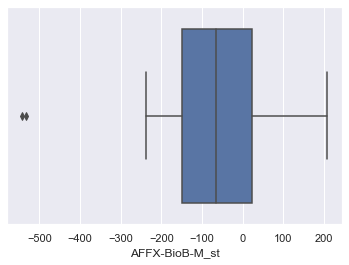

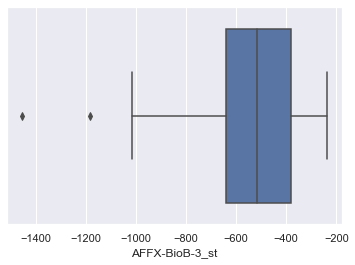

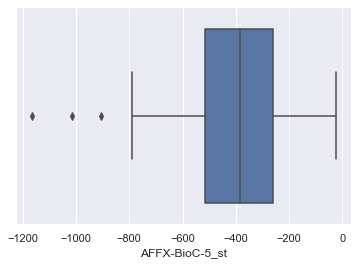

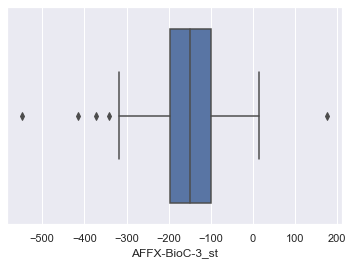

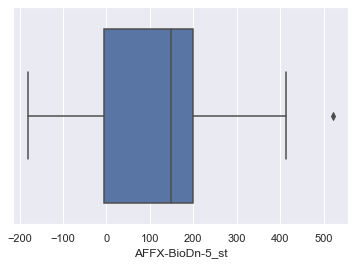

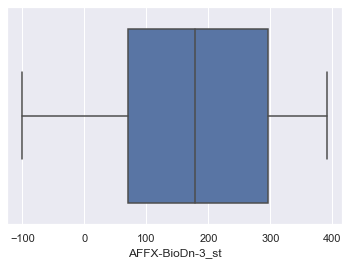

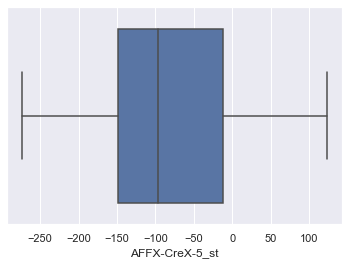

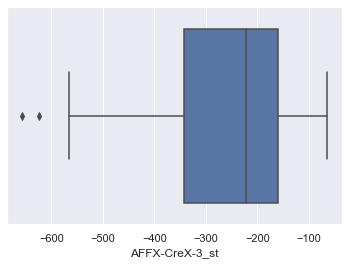

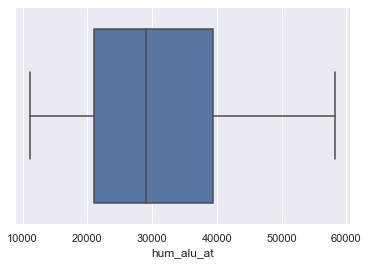

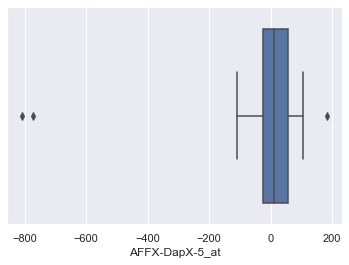

In [25]:
count = 0
for i in range(20):
    plt.figure(i)
    sns.boxplot(x=X_test[X_test.columns[i]])

## Remove Outliers Using Z Scores

In [26]:
# z = np.abs(stats.zscore(X_train.T))
# X_train_clean = X_train.T[(z<3).all(axis=1)]
# X_train_clean = X_train_clean.T
# X_train_clean.shape

In [27]:
# z = np.abs(stats.zscore(X_test.T))
# X_test_clean = X_test.T[(z<3).all(axis=1)]
# X_test_clean = X_test_clean.T
# X_test_clean.shape

## Train and Test Subsets

In [28]:
# X_train = X_train_clean.reset_index(drop=True)
X_train = X_train.reset_index(drop=True)
y_train = cancer_type_df[cancer_type_df.patient <= 38].reset_index(drop=True)

# X_test = X_test_clean.reset_index(drop=True)
X_test = X_test.reset_index(drop=True)
y_test = cancer_type_df[cancer_type_df.patient > 38].reset_index(drop=True)
X_train.shape

(38, 7129)

In [29]:
X_shared_columns = [column for column in X_train.columns if column in X_train.columns and column in X_test.columns]
len(X_shared_columns)

7129

In [30]:
X_train = X_train[[column for column in X_shared_columns if column in X_train.columns]]
X_train.head()

Gene Accession Number,AFFX-BioB-5_at,AFFX-BioB-M_at,AFFX-BioB-3_at,AFFX-BioC-5_at,AFFX-BioC-3_at,AFFX-BioDn-5_at,AFFX-BioDn-3_at,AFFX-CreX-5_at,AFFX-CreX-3_at,AFFX-BioB-5_st,...,U48730_at,U58516_at,U73738_at,X06956_at,X16699_at,X83863_at,Z17240_at,L49218_f_at,M71243_f_at,Z78285_f_at
0,-214,-153,-58,88,-295,-558,199,-176,252,206,...,185,511,-125,389,-37,793,329,36,191,-37
1,-139,-73,-1,283,-264,-400,-330,-168,101,74,...,169,837,-36,442,-17,782,295,11,76,-14
2,-76,-49,-307,309,-376,-650,33,-367,206,-215,...,315,1199,33,168,52,1138,777,41,228,-41
3,-135,-114,265,12,-419,-585,158,-253,49,31,...,240,835,218,174,-110,627,170,-50,126,-91
4,-106,-125,-76,168,-230,-284,4,-122,70,252,...,156,649,57,504,-26,250,314,14,56,-25


In [31]:
X_test = X_test[[column for column in X_shared_columns if column in X_test.columns]]
X_test.head()

Gene Accession Number,AFFX-BioB-5_at,AFFX-BioB-M_at,AFFX-BioB-3_at,AFFX-BioC-5_at,AFFX-BioC-3_at,AFFX-BioDn-5_at,AFFX-BioDn-3_at,AFFX-CreX-5_at,AFFX-CreX-3_at,AFFX-BioB-5_st,...,U48730_at,U58516_at,U73738_at,X06956_at,X16699_at,X83863_at,Z17240_at,L49218_f_at,M71243_f_at,Z78285_f_at
0,-342,-200,41,328,-224,-427,-656,-292,137,-144,...,277,1023,67,214,-135,1074,475,48,168,-70
1,-87,-248,262,295,-226,-493,367,-452,194,162,...,83,529,-295,352,-67,67,263,-33,-33,-21
2,-62,-23,-7,142,-233,-284,-167,-97,-12,-70,...,129,383,46,104,15,245,164,84,100,-18
3,22,-153,17,276,-211,-250,55,-141,0,500,...,413,399,16,558,24,893,297,6,1971,-42
4,86,-36,-141,252,-201,-384,-420,-197,-60,-468,...,341,91,-84,615,-52,1235,9,7,1545,-81


In [32]:
y_train.head()

,patient,cancer
0,1,0
1,2,0
2,3,0
3,4,0
4,5,0


In [33]:
X_train.describe()

Gene Accession Number,AFFX-BioB-5_at,AFFX-BioB-M_at,AFFX-BioB-3_at,AFFX-BioC-5_at,AFFX-BioC-3_at,AFFX-BioDn-5_at,AFFX-BioDn-3_at,AFFX-CreX-5_at,AFFX-CreX-3_at,AFFX-BioB-5_st,...,U48730_at,U58516_at,U73738_at,X06956_at,X16699_at,X83863_at,Z17240_at,L49218_f_at,M71243_f_at,Z78285_f_at
count,38.000000,38.000000,38.000000,38.000000,38.000000,38.000000,38.000000,38.000000,38.000000,38.000000,...,38.000000,38.000000,38.000000,38.000000,38.000000,38.000000,38.000000,38.000000,38.000000,38.000000
mean,-120.868421,-150.526316,-17.157895,181.394737,-276.552632,-439.210526,-43.578947,-201.184211,99.052632,112.131579,...,178.763158,750.842105,8.815789,399.131579,-20.052632,869.052632,335.842105,19.210526,504.394737,-29.210526
std,109.555656,75.734507,117.686144,117.468004,111.004431,135.458412,219.482393,90.838989,83.178397,211.815597,...,84.826830,298.008392,77.108507,469.579868,42.346031,482.366461,209.826766,31.158841,728.744405,30.851132
min,-476.000000,-327.000000,-307.000000,-36.000000,-541.000000,-790.000000,-479.000000,-463.000000,-82.000000,-215.000000,...,30.000000,224.000000,-178.000000,36.000000,-112.000000,195.000000,41.000000,-50.000000,-2.000000,-94.000000
25%,-138.750000,-205.000000,-83.250000,81.250000,-374.250000,-547.000000,-169.000000,-239.250000,36.000000,-47.000000,...,120.000000,575.500000,-42.750000,174.500000,-48.000000,595.250000,232.750000,8.000000,136.000000,-42.750000
50%,-106.500000,-141.500000,-43.500000,200.000000,-263.000000,-426.500000,-33.500000,-185.500000,99.500000,70.500000,...,174.500000,700.000000,10.500000,266.000000,-18.000000,744.500000,308.500000,20.000000,243.500000,-26.000000
75%,-68.250000,-94.750000,47.250000,279.250000,-188.750000,-344.750000,79.000000,-144.750000,152.250000,242.750000,...,231.750000,969.500000,57.000000,451.750000,9.250000,1112.000000,389.500000,30.250000,487.250000,-11.500000
max,17.000000,-20.000000,265.000000,392.000000,-51.000000,-155.000000,419.000000,-24.000000,283.000000,561.000000,...,356.000000,1653.000000,218.000000,2527.000000,52.000000,2315.000000,1109.000000,115.000000,3193.000000,36.000000


# Data Correlation

In [34]:
# sns.heatmap(X_train.corr(), fmt='.2g', annot=True)

In [35]:
# Counting 1 and 0 Value in Outcome column
# color_wheel = {1: "#0392cf", 2: "#7bc043"}
# colors = y_train["cancer"].map(lambda x: color_wheel.get(x + 1))
# print(X_train.Outcome.value_counts())
# p=X_train.Outcome.value_counts().plot(kind="bar")

In [36]:
# sc_X = StandardScaler()
# X = pd.DataFrame(sc_X.fit_transform(X_train)
# X.head()

# PCA

In [37]:
pca = PCA()
pca.fit_transform(X_train)

array([[-4.12032149e+03,  8.43574289e+03, -1.39441668e+04, ...,
         2.51106855e+03,  3.92187680e+03,  1.22642865e-11],
       [ 1.86283598e+04,  1.44078238e+04,  1.66177453e+04, ...,
        -2.30960132e+02, -1.04099055e+03,  1.22642865e-11],
       [-1.58238732e+04,  1.40484268e+04,  4.73320627e+04, ...,
         5.48675197e+02, -2.26227734e+03,  1.22642865e-11],
       ...,
       [ 6.50848905e+04, -5.49595793e+04,  1.67854688e+04, ...,
         1.18708820e+01, -1.47894896e+03,  1.22642865e-11],
       [ 4.97670530e+04, -3.81956823e+04,  2.93511865e+03, ...,
         2.66462156e+03,  7.99461277e+02,  1.22642865e-11],
       [ 1.08241948e+04, -1.68550421e+04, -9.46017931e+02, ...,
        -2.04773331e+03, -1.96917341e+03,  1.22642865e-11]])

22 features explain around 90% of the variance. From 7129 features to 22, not too bad.


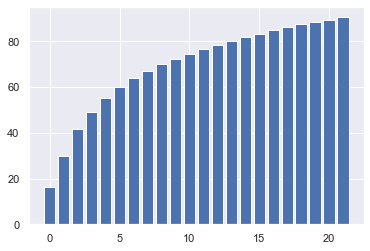

In [38]:
total = sum(pca.explained_variance_)
k = 0
current_variance = 0
while current_variance/total < 0.90:
    current_variance += pca.explained_variance_[k]
    k = k + 1
    
print(k, " features explain around 90% of the variance. From 7129 features to ", k, ", not too bad.", sep='')

pca = PCA(n_components=k)
X_train.pca = pca.fit(X_train)
X_train_pca = pca.transform(X_train)
X_test_pca = pca.transform(X_test)

var_exp = pca.explained_variance_ratio_.cumsum()
var_exp = var_exp*100
plt.bar(range(k), var_exp);

# Build Machine Learning Model

In [39]:
# test size 20% and train size 80%
# from sklearn.model_selection import train_test_split, cross_val_score, cross_val_predict
# from sklearn.metrics import classification_report, confusion_matrix

# X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.2,random_state=7)

In [40]:
X_train
y_train = y_train["cancer"]
y_test = y_test["cancer"]

# Random Forest

In [41]:
from sklearn.ensemble import RandomForestClassifier

rfc = RandomForestClassifier(n_estimators=200)
rfc.fit(X_train, y_train)

RandomForestClassifier(n_estimators=200)

In [42]:
rfc_train = rfc.predict(X_train)
from sklearn import metrics

print("Accuracy_Score =", format(metrics.accuracy_score(y_train, rfc_train)))

Accuracy_Score = 1.0


In [43]:
from sklearn import metrics

predictions = rfc.predict(X_test)
print("Accuracy_Score =", format(metrics.accuracy_score(y_test, predictions)))

Accuracy_Score = 0.7647058823529411


In [44]:
from sklearn.metrics import classification_report, confusion_matrix

print(confusion_matrix(y_test, predictions))
print(classification_report(y_test,predictions))

[[20  0]
 [ 8  6]]
              precision    recall  f1-score   support

           0       0.71      1.00      0.83        20
           1       1.00      0.43      0.60        14

    accuracy                           0.76        34
   macro avg       0.86      0.71      0.72        34
weighted avg       0.83      0.76      0.74        34



# Decision Tree

In [45]:
from sklearn.tree import DecisionTreeClassifier

dtree = DecisionTreeClassifier()
dtree.fit(X_train, y_train)

DecisionTreeClassifier()

In [46]:
y_pred = dtree.predict(X_test)
print("Classification report - \n", classification_report(y_test,y_pred))

Classification report - 
               precision    recall  f1-score   support

           0       0.95      0.90      0.92        20
           1       0.87      0.93      0.90        14

    accuracy                           0.91        34
   macro avg       0.91      0.91      0.91        34
weighted avg       0.91      0.91      0.91        34



Text(0.5, 1.0, 'Accuracy Score: 0.9117647058823529')

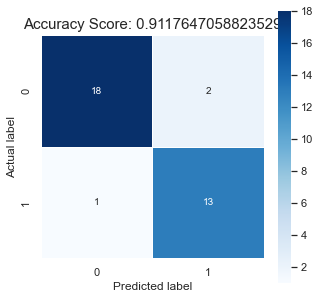

In [47]:
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(5,5))
sns.heatmap(data=cm,linewidths=.5, annot=True,square = True,  cmap = 'Blues')
plt.ylabel('Actual label')
plt.xlabel('Predicted label')
all_sample_title = 'Accuracy Score: {0}'.format(dtree.score(X_test, y_test))
plt.title(all_sample_title, size = 15)

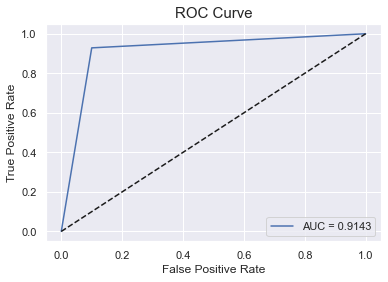

In [48]:
from sklearn.metrics import roc_curve, roc_auc_score
y_pred_proba = dtree.predict_proba(X_test)[:][:,1]

df_actual_predicted = pd.concat([pd.DataFrame(np.array(y_test), columns=['y_actual']), pd.DataFrame(y_pred_proba, columns=['y_pred_proba'])], axis=1)
df_actual_predicted.index = y_test.index

fpr, tpr, tr = roc_curve(df_actual_predicted['y_actual'], df_actual_predicted['y_pred_proba'])
auc = roc_auc_score(df_actual_predicted['y_actual'], df_actual_predicted['y_pred_proba'])

plt.plot(fpr, tpr, label='AUC = %0.4f' %auc)
plt.plot(fpr, fpr, linestyle = '--', color='k')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve', size = 15)
plt.legend()

# XGBoost

In [49]:
from xgboost import XGBClassifier

xgb_model = XGBClassifier(gamma=0)
xgb_model.fit(X_train, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
              importance_type=None, interaction_constraints='',
              learning_rate=0.300000012, max_bin=256, max_cat_to_onehot=4,
              max_delta_step=0, max_depth=6, max_leaves=0, min_child_weight=1,
              missing=nan, monotone_constraints='()', n_estimators=100,
              n_jobs=0, num_parallel_tree=1, predictor='auto', random_state=0,
              reg_alpha=0, reg_lambda=1, ...)

In [50]:
from sklearn import metrics

xgb_pred = xgb_model.predict(X_test)
print("Accuracy Score =", format(metrics.accuracy_score(y_test, xgb_pred)))

Accuracy Score = 0.9117647058823529


In [51]:
from sklearn.metrics import classification_report, confusion_matrix

print(confusion_matrix(y_test, xgb_pred))
print(classification_report(y_test,xgb_pred))

[[18  2]
 [ 1 13]]
              precision    recall  f1-score   support

           0       0.95      0.90      0.92        20
           1       0.87      0.93      0.90        14

    accuracy                           0.91        34
   macro avg       0.91      0.91      0.91        34
weighted avg       0.91      0.91      0.91        34



# Support Vector Machine

In [52]:
from sklearn.svm import SVC

svc_model = SVC()
svc_model.fit(X_train, y_train)

SVC()

In [53]:
svc_pred = svc_model.predict(X_test)

In [54]:
from sklearn import metrics

print("Accuracy Score =", format(metrics.accuracy_score(y_test, svc_pred)))

Accuracy Score = 0.6176470588235294


In [55]:
from sklearn.metrics import classification_report, confusion_matrix

print(confusion_matrix(y_test, svc_pred))
print(classification_report(y_test,svc_pred))

[[20  0]
 [13  1]]
              precision    recall  f1-score   support

           0       0.61      1.00      0.75        20
           1       1.00      0.07      0.13        14

    accuracy                           0.62        34
   macro avg       0.80      0.54      0.44        34
weighted avg       0.77      0.62      0.50        34



# Logistic Regression

Best Parameters:
 {'C': 1, 'penalty': 'l1'}
Logistic Regression accuracy: 1.0


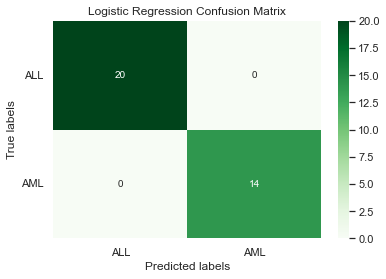

In [56]:
from sklearn.metrics import classification_report

labels = ['ALL', 'AML']

log_grid = {'C': [1e-03, 1e-2, 1e-1, 1, 10], 
                 'penalty': ['l1', 'l2']}

log_estimator = LogisticRegression(solver='liblinear')

log_model = GridSearchCV(estimator=log_estimator, 
                  param_grid=log_grid, 
                  cv=3,
                  scoring='accuracy')

log_model.fit(X_train, y_train)

print("Best Parameters:\n", log_model.best_params_)

# Select best log model
best_log = log_model.best_estimator_

# Make predictions using the optimised parameters
log_pred = best_log.predict(X_test)

print('Logistic Regression accuracy:', round(accuracy_score(y_test, log_pred), 3))

cm_log = confusion_matrix(y_test, log_pred)

ax = plt.subplot()
sns.heatmap(cm_log, annot=True, ax = ax, fmt='g', cmap='Greens') 

# labels, title and ticks
ax.set_xlabel('Predicted labels')
ax.set_ylabel('True labels') 
ax.set_title('Logistic Regression Confusion Matrix') 
ax.xaxis.set_ticklabels(labels) 
ax.yaxis.set_ticklabels(labels, rotation=360);

# Feature Importance

In [57]:
dtree.feature_importances_

array([0., 0., 0., ..., 0., 0., 0.])

<AxesSubplot:ylabel='Gene Accession Number'>

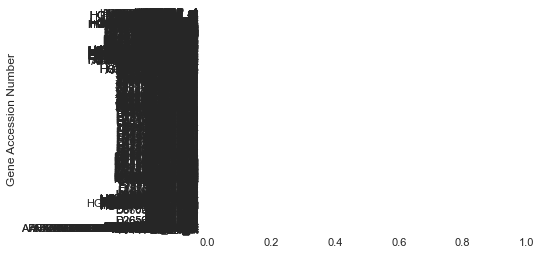

In [58]:
(pd.Series(dtree.feature_importances_, index=X_train.columns).plot(kind='barh'))

# Make Prediction

In [71]:
y_test

0     0
1     0
2     0
3     0
4     0
5     0
6     0
7     0
8     0
9     0
10    0
11    1
12    1
13    1
14    1
15    1
16    0
17    0
18    1
19    1
20    0
21    1
22    1
23    1
24    1
25    1
26    1
27    1
28    0
29    0
30    0
31    0
32    0
33    0
Name: cancer, dtype: int64

In [63]:
X_test.head()

Gene Accession Number,AFFX-BioB-5_at,AFFX-BioB-M_at,AFFX-BioB-3_at,AFFX-BioC-5_at,AFFX-BioC-3_at,AFFX-BioDn-5_at,AFFX-BioDn-3_at,AFFX-CreX-5_at,AFFX-CreX-3_at,AFFX-BioB-5_st,...,U48730_at,U58516_at,U73738_at,X06956_at,X16699_at,X83863_at,Z17240_at,L49218_f_at,M71243_f_at,Z78285_f_at
0,-342,-200,41,328,-224,-427,-656,-292,137,-144,...,277,1023,67,214,-135,1074,475,48,168,-70
1,-87,-248,262,295,-226,-493,367,-452,194,162,...,83,529,-295,352,-67,67,263,-33,-33,-21
2,-62,-23,-7,142,-233,-284,-167,-97,-12,-70,...,129,383,46,104,15,245,164,84,100,-18
3,22,-153,17,276,-211,-250,55,-141,0,500,...,413,399,16,558,24,893,297,6,1971,-42
4,86,-36,-141,252,-201,-384,-420,-197,-60,-468,...,341,91,-84,615,-52,1235,9,7,1545,-81


In [73]:
X_test.iloc[10:15, :]

Gene Accession Number,AFFX-BioB-5_at,AFFX-BioB-M_at,AFFX-BioB-3_at,AFFX-BioC-5_at,AFFX-BioC-3_at,AFFX-BioDn-5_at,AFFX-BioDn-3_at,AFFX-CreX-5_at,AFFX-CreX-3_at,AFFX-BioB-5_st,...,U48730_at,U58516_at,U73738_at,X06956_at,X16699_at,X83863_at,Z17240_at,L49218_f_at,M71243_f_at,Z78285_f_at
10,-256,-249,-410,24,-535,-810,709,-316,27,14,...,76,1455,-123,491,-55,1950,906,79,170,-64
11,-118,-142,212,314,-401,-452,-336,-310,177,-131,...,134,690,-8,331,-62,882,264,73,315,7
12,-112,-185,24,170,-197,-400,-215,-227,100,307,...,146,621,34,295,4,1110,174,8,533,-4
13,-21,-13,8,38,-128,-245,409,-102,85,281,...,-58,229,-11,201,-35,133,50,-51,91,-43
14,-202,-274,59,309,-456,-581,-159,-343,236,-7,...,205,470,-53,392,-106,523,577,-26,208,-71


In [68]:
log_model.predict([X_test.iloc[1,:]])

array([0], dtype=int64)

In [74]:
log_model.predict([X_test.iloc[11,:]])

array([1], dtype=int64)